In [117]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import matching
from tqdm import tqdm
from collections import OrderedDict
from config import *
import data
import util

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
dists_vgg = data.get_dists('vgg')
dists_facial = data.get_dists('facial')

# look at some matches

In [2]:
print([k for k in os.listdir(DIR_PROCESSED_MISC) if '14_' in k])
k_group = 'gender' # gender
matches = pd.read_pickle(oj(DIR_PROCESSED_MISC, '14_matches_gender_200.pkl'))

# match indexes are in original space [0, 30000)
# this is the same as the df.index [0, 30000)
match_keys = OrderedDict({
    f'{k_group}_0_ref': 'dist_ref0',
    f'{k_group}_0': 'dist',
    f'{k_group}_1': 'dist',
    f'{k_group}_1_ref': 'dist_ref1'
})
ks_matched = [k for k in match_keys if not 'ref' in k]
idxs_matched = matches[ks_matched].values
d_matched = df.iloc[idxs_matched.flatten()]

['14_matches_black_or_white_39.pkl', '14_matches_gender_200.pkl', '14_matches_gender_12.pkl', '14_matches_black_or_white_12.pkl']


In [ ]:
N_PLOT = 18
ks = match_keys.keys()
r = {k: [] for k in match_keys.keys()}
for i, match in tqdm(matches.iterrows()):
    for k in r.keys():
        d = df.iloc[int(match[k])]
        r[k].append(mpimg.imread(oj(DIR_IMS, d.fname_final)))

for i, k in enumerate(ks):
    util.plot_row(r[k][:N_PLOT],
                  annot_list=matches[match_keys[k]][:N_PLOT].round(1),
                  ylab=k.capitalize())
    plt.savefig(f'results/{k}.png', dpi=150)

# mean diff checking

In [71]:
# add Race = Black
df.loc[df['race4_pred'] == 'Black', 'black'] = 1
d_matched.loc[d_matched['race4_pred'] == 'Black', 'black'] = 1

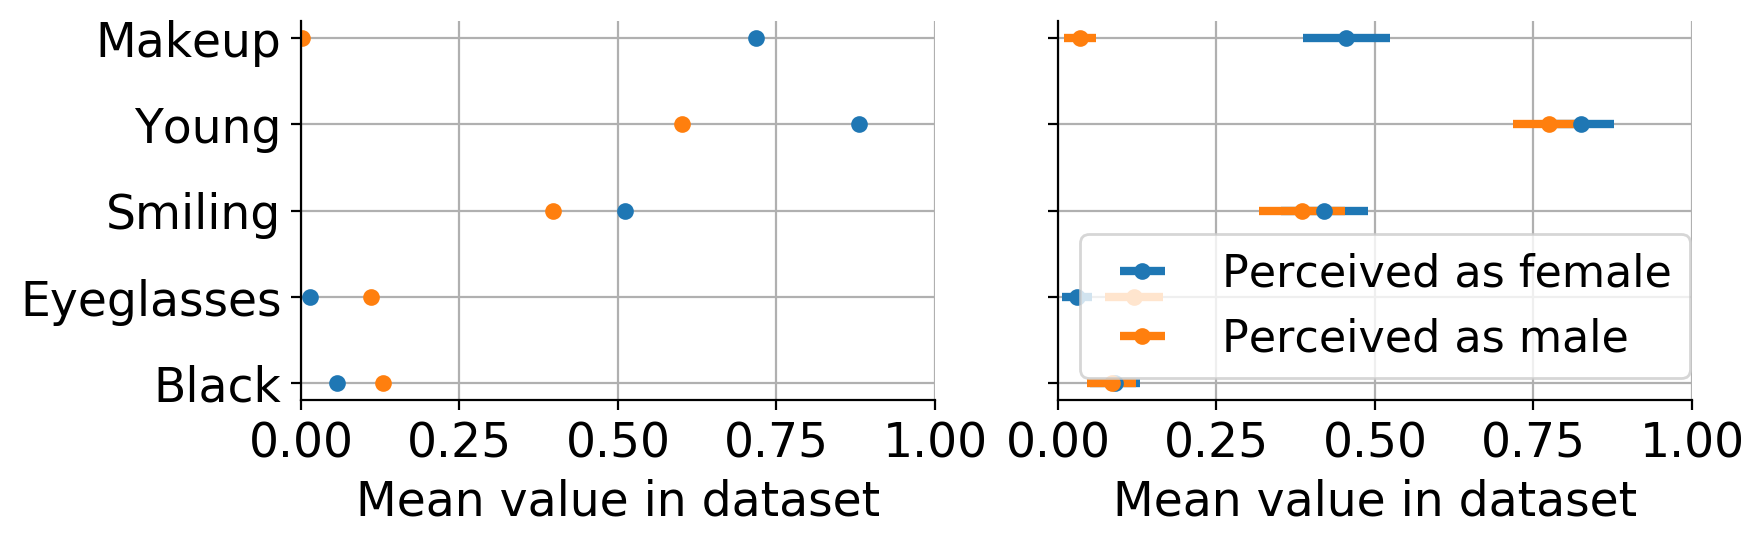

In [82]:
R, C = 1, 2
plt.figure(dpi=200, figsize=(12, 3))
ks = [ #'yaw', 'pitch', 'roll',
      'eyeglasses', 'makeup', 'gender',
      'black', 'young', 'smiling'] #, 'background_mean']
args = None
for i, d in enumerate([df, d_matched]):
    
    d = d[ks]

    # normalize to [0, 1]
    d = (d - d.min()) / (d.max() - d.min())

    k_group = 'gender'
    
    g0 = d[d[k_group] == 0]
    g1 = d[d[k_group] == 1]
    
    ax = plt.subplot(R, C, i + 1)
    args = matching.plot_subgroup_means(g0, g1, ks=np.array([k for k in ks if not k == k_group]),
                                        ticklabels=i == 0, args=args)
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('means_matching')
plt.legend()    
plt.show()

# secondary match dist checking

**dists between ref and matched photos**

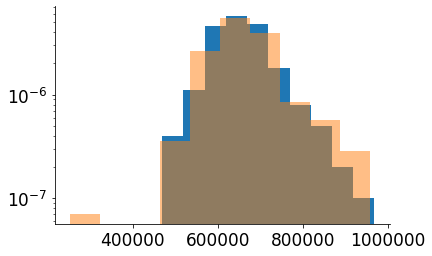

In [121]:
density = True
ks0 = [k for k in match_keys if '_0' in k]
ds_vgg0 = [dists_vgg[x[0], x[1]] for x in matches[ks0].values]
ks1 = [k for k in match_keys if '1' in k]
ds_vgg1 = [dists_vgg[x[0], x[1]] for x in matches[ks1].values]
plt.hist(ds_vgg0, density=density, bins=10)
plt.hist(ds_vgg1, density=density, alpha=0.5, bins=10)
plt.yscale('log')
plt.show()

**dists for random pairs in original data**

In [ ]:
ds_orig = {
    0: [],
    1: [],
}
for val in ds_orig.keys():
    d = df[df['count_with_this_id'] > 1]
    d = d[d[k_group] == val]
    ids = sorted(d.id.unique())
    for i in tqdm(ids):
        r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
        ds_orig[val].append(dists_vgg[r2[0], r2[1]])
plt.hist(ds_orig[0], density=density)
plt.hist(ds_orig[1], density=density, alpha=0.5)
plt.yscale('log')

# facial-rec dist benchmarking

**calculate original dists**

In [ ]:
sorted(df.index)


100%|██████████| 2636/2636 [00:02<00:00, 1034.76it/s]

100%|██████████| 1880/1880 [00:01<00:00, 1040.68it/s]


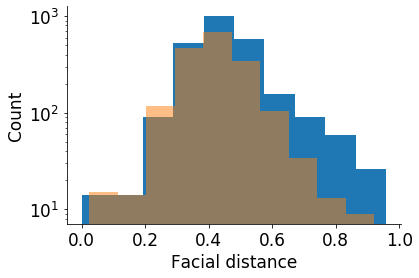

In [122]:
def hist_dists(r, density=False):
    plt.hist(r[0], density=density)
    plt.hist(r[1], density=density, alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Facial distance')
    plt.ylabel('Count')
    plt.show()
    
ds_orig = {
    0: [],
    1: [],
}
for val in ds_orig.keys():
    d = df[df['count_with_this_id'] > 1]
    d = d[d[k_group] == val]
    ids = sorted(d.id.unique())
    for i in tqdm(ids):
        r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
        dist = dists_facial[r2[0], r2[1]]
        if not dist == 1e3:
            ds_orig[val].append(dist)
hist_dists(ds_orig)

# ds = dists_facial[0:5].flatten()
# plt.hist(ds[ds!=1e3])
# plt.show()

**calculate new facial dists**

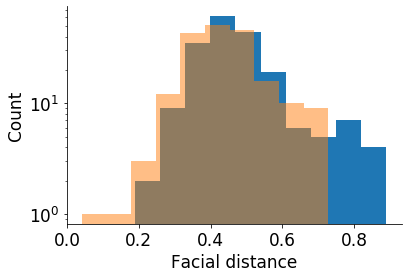

In [123]:
r = {}
for i in [0, 1]:
    idxs_match = matches[k_group + '_' + str(i)].values
    idxs_ref = matches[k_group + '_' + str(i) + '_ref'].values
    r[i] = [dists_facial[r, c]
            for (r, c) in zip(idxs_match, idxs_ref)
            if not dists_facial[r, c] == 1e3]
r = pd.DataFrame.from_dict(r)
hist_dists(r)

**plot differences**

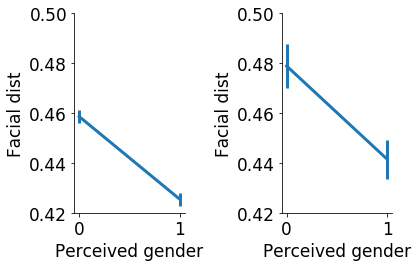

In [128]:
ylims = (0.42, 0.5)
# plot orig
R, C = 1, 2
plt.subplot(R, C, 1)
ks_orig = [0, 1]
means_orig = [np.mean(ds_orig[k]) for k in ks_orig]
sems_orig = [np.std(ds_orig[k]) / np.sqrt(len(ds_orig[k])) for k in ks_orig]
plt.errorbar(ks_orig, means_orig, yerr=sems_orig)
plt.ylabel('Facial dist')
plt.xlabel(f'Perceived {k_group}')
plt.ylim(ylims)

# plot new
plt.subplot(R, C, 2)
vals = [0, 1]
plt.errorbar(vals, r.mean(), yerr=r.sem())
plt.ylabel('Facial dist')
plt.xlabel(f'Perceived {k_group}')
plt.ylim(ylims)

plt.tight_layout()
util.savefig('bias_benchmarking')